In [5]:
# Import necessary libraries
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

In [6]:
class ArmedBanditsEnv():
    """
    num_expt -> number of experiments 
    num_slots -> available slots that can transmit data based on availablility
    p_values -> num_expts x num_slots matrix containing p-values for availability of slot
    action -> num_expts x num_slots array denoting the order of checking slots for availability for each expt
    """
    
    def __init__(self, p_values):
        assert len(p_values.shape) == 2
        
        self.num_slots = p_values.shape[1]
        self.num_expts = p_values.shape[0]
        self.state = np.zeros((self.num_expts,self.num_slots))
        
        self.p_values = p_values

    def generate_state(self):
        return np.random.binomial(n=1,p=self.p_values)
    
        
    def step(self, action_type, action):
        
        # Sample from the specified slot using it's bernoulli distribution
        assert (action.shape == (self.num_expts,self.num_slots))
        
        sampled_state = np.random.binomial(n=1, p=self.p_values)

        self.state = sampled_state

        cost = np.zeros((self.num_expts, 1))

        for j in range(self.num_expts):
            # Get the relevant actions and their indices for the current experiment
            if action_type[j]==0:
                cost[j]=self.num_slots
            else:
                actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
                relevant_states = sampled_state[j, actions]
                # Find the index of the first occurrence of 1, if any
                indices = np.where(relevant_states == 1)[0]
                if indices.size > 0:
                    first_one_index = indices[0]
                else:
                    first_one_index = len(actions)-1
                # Calculate the cost
                cost[j] = first_one_index+1
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        assert (cost.shape[1]==1)
        return cost,self.state, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsBernoulli(ArmedBanditsEnv):
    def __init__(self, num_expts=1, num_slots=5):
        self.p_values = np.random.uniform(0, 1, (num_expts, num_slots))
        
        ArmedBanditsEnv.__init__(self, self.p_values)

In [7]:
p_values = np.array([[0.1, 0.4, 0.2, 0.3]]) # The p_values for a four-slot channel. Single experiment

env = ArmedBanditsEnv(p_values) # Create the environment

for i in range(4):
    action = np.random.choice(range(1, 5), size=(1,4), replace=False)
    cost,state, _, _ = env.step([1],action)
    print("State:",state ,"on Order:", action, " gave a cost of:",cost[0])

State: [[0 1 0 1]] on Order: [[4 3 2 1]]  gave a cost of: [1.]
State: [[0 1 1 0]] on Order: [[2 1 3 4]]  gave a cost of: [1.]
State: [[0 0 0 0]] on Order: [[3 2 4 1]]  gave a cost of: [4.]
State: [[0 1 0 0]] on Order: [[1 2 3 4]]  gave a cost of: [2.]


In [8]:
def inc_p(prev_p, new_val, n):
    return (prev_p*(n-1) + new_val)/n
inc_p_vect = np.vectorize(inc_p)


In [9]:
def greedy_order(estimates):
    """
    Takes in an array of estimates of num_expts x num_slots and returns the order
    of slots with the decreasing estimated p_value for each row. 
    Breaks ties randomly by introducing a small random noise.
    """
    if estimates.ndim == 1:
        sorted_indices = sort_with_noise(estimates)
    else:
        sorted_indices = np.apply_along_axis(sort_with_noise, 1, estimates)
    return sorted_indices

def sort_with_noise(row):
    # Identifying unique values and their counts
    unique, counts = np.unique(row, return_counts=True)
    
    # Only add noise to elements where there are ties
    for value, count in zip(unique, counts):
        if count > 1:
            noise = np.random.normal(0, 1e-6, count)  # Small noise
            indices = row == value
            row[indices] += noise

    # Sort the indices after adding noise
    sorted_indices = np.argsort(-row) + 1
    return sorted_indices


In [ ]:
estimates_1d = np.array([0.2, 0.2, 0.07, 0.1])
print(greedy_order(estimates_1d))

estimates_2d = np.array([[0.1, 0.3, 0.05, 0.2], [0.4, 0.2, 0.1, 0.3]])
print(greedy_order(estimates_2d))

## Optimal Agent

In [10]:
class OptimalAgent():
    def __init__(self, p_values):
        
        # Store the epsilon value
        
        
        self.num_slots = p_values.shape[1]
        self.num_expts = p_values.shape[0]
        self.estimates = p_values.astype(np.float64)
        
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = np.tile([0],(self.num_expts,1))
        
        # Generate both types of actions for every experiment
        
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_order(p_values)
        return action_type,action
    
    def update_estimates(self, cost, state, action_type, action):
        return 0
             
        

## THE GREEDY AGENT

It can be derived directly from greedy epsilon agent created later.

## Epsilon-Greedy Agent

In [11]:
class EpsilonGreedyAgent():
    def __init__(self, estimates, epsilon):
        
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        assert len(estimates.shape) == 2
        
        self.num_slots = estimates.shape[1]
        self.num_expts = estimates.shape[0]
        self.estimates = estimates.astype(np.float64)
        self.action_count = np.zeros(estimates.shape)
        self.epsilon = epsilon
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_expts) > self.epsilon).astype(int).reshape(-1,1)
        
        # Generate both types of actions for every experiment
        exploratory_action = np.tile(np.arange(1, self.num_slots + 1), (self.num_expts, 1))
        greedy_action = greedy_order(self.estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        return action_type,action
    
    def update_estimates(self, cost, state, action_type, action):
        for j in range(self.num_expts):
            if action_type[j]==0:
                # Increment action_count for all slots
                self.action_count[j] += 1
        
                # Apply the vectorized inc_p function to the entire row
                n = self.action_count[j]
                self.estimates[j] = inc_p(self.estimates[j], state[j], n)
            else:

                num_expts, num_slots = action.shape

            
                c = int(cost[j][0])-1

                if c>0:
                    changed = action[j][:c]-1
                    
                    # Update the estimates and counts for the changed actions
                    self.action_count[j, changed] += 1

                    self.estimates[j, changed] = inc_p(self.estimates[j, changed], 0, self.action_count[j, changed])
                    
                    

                # Update the estimates and counts for the not-changed action, if it exists
                if c == num_slots-1:
                    self.action_count[j, c] += 1
                    self.estimates[j, c] = inc_p(self.estimates[j, c], state[j,c], self.action_count[j, c])
                else :
                    self.action_count[j, c] += 1
                    self.estimates[j, c] = inc_p(self.estimates[j, c], 1, self.action_count[j, c])
            
             
        

In [12]:
agent = EpsilonGreedyAgent(np.array([[0,0,0,0]]),0)

cost = np.array([[3]])
state = np.array([[0,0,1,1]])
action_type = np.array([[1]])
action = np.array([[1,2,3,4]])

agent.update_estimates(cost,state,action_type,action)
print(agent.estimates)

state = np.array([[0,0,0,0]])
cost = np.array([[4]])

agent.update_estimates(cost,state,action_type,action)
print(agent.estimates)


state = np.array([[0,0,0,1]])
cost = np.array([[4]])

agent.update_estimates(cost,state,action_type,action)
print(agent.estimates)

state = np.array([[1,0,0,0]])
cost = np.array([[1]])

agent.update_estimates(cost,state,action_type,action)
print(agent.estimates)


[[0. 0. 1. 0.]]
[[0.  0.  0.5 0. ]]
[[0.         0.         0.33333333 0.5       ]]
[[0.25       0.         0.33333333 0.5       ]]


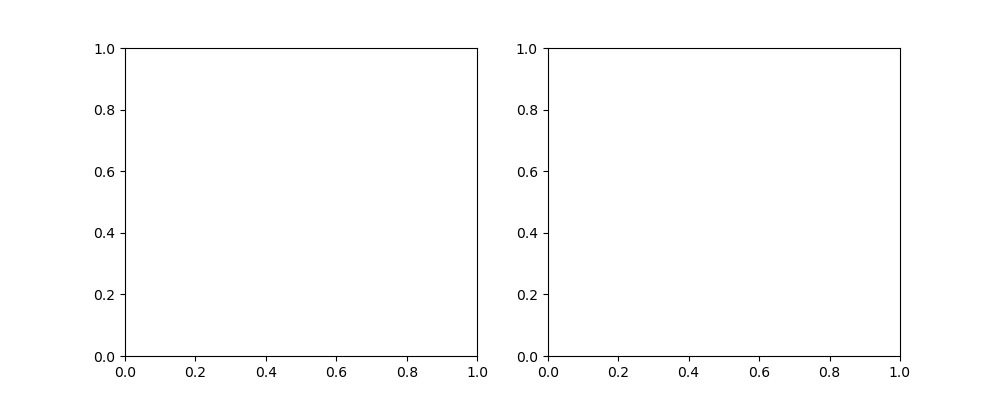

In [37]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0.1)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action = agent.get_action()
    cost,state,_,_ = env.step(action_type,action)
    agent.update_estimates(cost,state,action_type,action)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        # [Rest of the step function code]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()



Greedy agent is derived by taking epsilon as 0

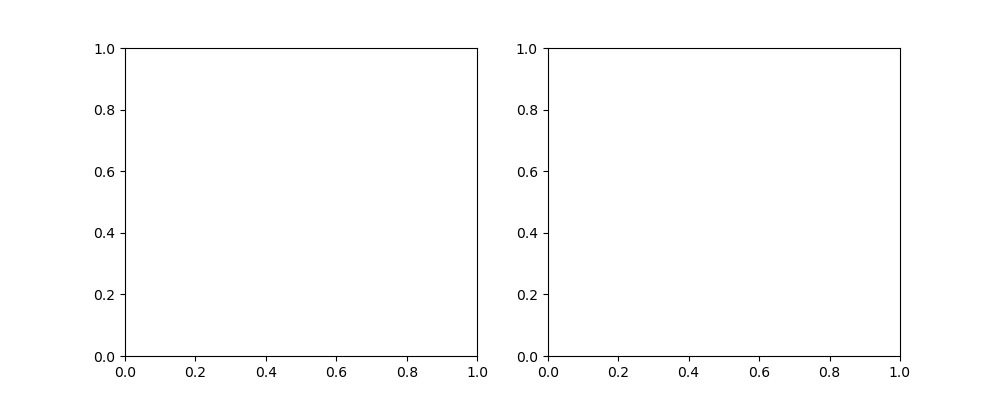

In [38]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action = agent.get_action()
    cost,state,_,_ = env.step(action_type,action)
    agent.update_estimates(cost,state,action_type,action)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        # [Rest of the step function code]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()



In [39]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


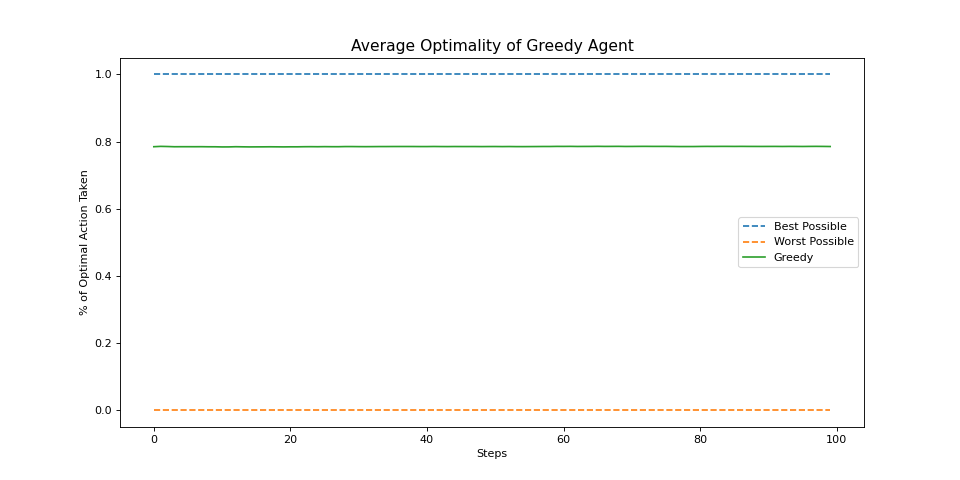

In [40]:
num_expts = 10000
num_steps = 100
num_slots = 10

# Initialize the environment
env = ArmedBanditsBernoulli(num_expts, num_slots)
# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0)

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_expts, num_steps+1))

#Store the optimal actions for later use
optimal = greedy_order(env.p_values)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action_type,action = agent.get_action()
    cost,state, _, _ = env.step(action_type,action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(cost,state,action_type,action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + cost.flatten()
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    similarities = [cosine_similarity(action[i, :], optimal[i, :]) for i in range(num_expts)]

    current_optimality = np.mean(similarities)
    optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

In [61]:



def run_experiment(num_expts=1, num_steps=100, num_slots=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsBernoulli(num_expts, num_slots)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_expts, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = greedy_order(env.p_values)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action_type,action = agent.get_action()
        
        cost,state, _, _ = env.step(action_type,action)
        #print("cost shape",cost.shape)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(cost,state,action_type,action)
        
        # Store the average cumulative score and optimality of the current step
        #print("scores[:,i] shape",scores[:,i].shape)
        scores[:,i+1] = (scores[:,i] + cost.flatten())
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        similarities = [cosine_similarity(action[i, :], optimal[i, :]) for i in range(num_expts)]

        current_optimality = np.mean(similarities)
        # Get optimal actions from the environment
        
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


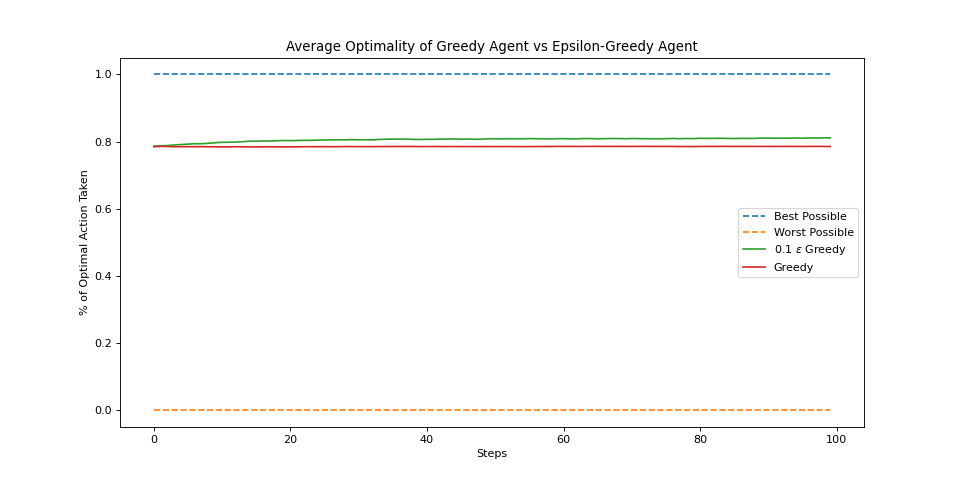

In [62]:
num_experiments = 10000
num_steps = 100
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')

plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 $\epsilon$ Greedy", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

In [13]:
def give_Cost(num_expts,num_slots,sampled_state,action_type,action):
    cost = np.zeros((num_expts, 1))

    for j in range(num_expts):
        # Get the relevant actions and their indices for the current experiment
        if action_type[j]==0:
            cost[j]=num_slots
        else:
            actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
            relevant_states = sampled_state[j, actions]
            # Find the index of the first occurrence of 1, if any
            indices = np.where(relevant_states == 1)[0]
            if indices.size > 0:
                first_one_index = indices[0]
            else:
                first_one_index = len(actions)-1
            # Calculate the cost
            cost[j] = first_one_index+1
    return cost

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


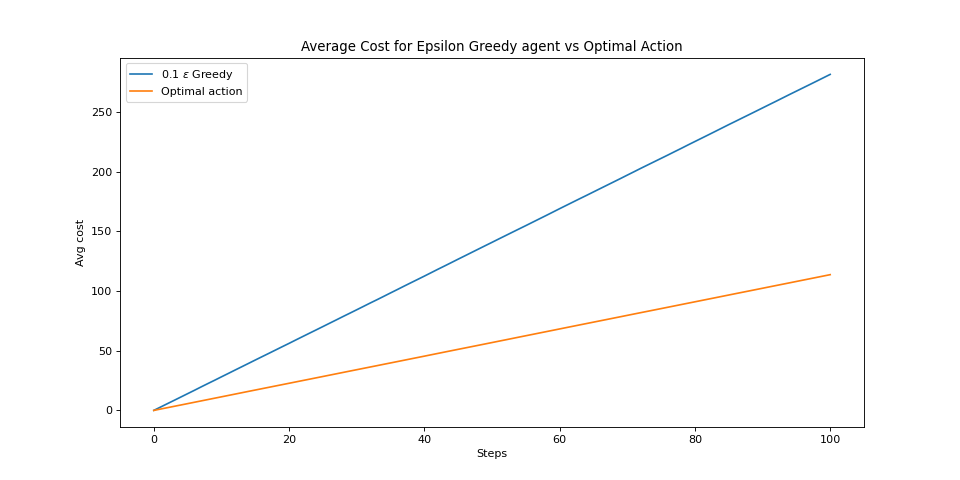

In [69]:
num_steps = 100
num_expts = 10000
num_slots = 10
epsilon = 0.1

agent_costs = np.zeros((num_expts,num_steps+1))
optimal_costs = np.zeros((num_expts,num_steps+1))

env = ArmedBanditsBernoulli(num_expts,num_slots)
optimal_action_type,optimal_action = np.ones((num_expts,1)),greedy_order(env.p_values)
epsilon = 0.1

agent = EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),epsilon)
for i in tqdm(range(num_steps)):
    action_type,action = agent.get_action()
    cost,state,_,_ = env.step(action_type,action)
    optimal_cost = give_Cost(num_expts,num_slots,state,optimal_action_type,optimal_action)
    agent_costs[:,i+1] = agent_costs[:,i] + cost.flatten()
    optimal_costs[:,i+1] = optimal_costs[:,i] + optimal_cost.flatten() 
    

agent_costs = agent_costs.mean(axis=0)
optimal_costs = optimal_costs.mean(axis=0)



plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(agent_costs)
plt.plot(optimal_costs)
plt.legend(["0.1 $\epsilon$ Greedy", "Optimal action"])
plt.title("Average Cost for Epsilon Greedy agent vs Optimal Action")
plt.ylabel("Avg cost")
plt.xlabel("Steps")
plt.show()


## UCB AGENT

We need to implement the confidence interval along with the estimates for UCB

In [14]:
class UCBAgent():
    def __init__(self, estimates,radius, epsilon ,steps):
        
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        assert len(estimates.shape) == 2
        
        self.num_slots = estimates.shape[1]
        self.num_expts = estimates.shape[0]
        self.estimates = estimates.astype(np.float64)
        self.radius = radius.astype(np.float64)
        self.action_count = np.zeros(estimates.shape)
        self.epsilon = epsilon
        self.total_steps = steps
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_expts) > self.epsilon).astype(int).reshape(-1,1)
        
        # Generate both types of actions for every experiment
        exploratory_action = np.tile(np.arange(1, self.num_slots + 1), (self.num_expts, 1))
        greedy_action = greedy_order(self.estimates + self.radius)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        return action_type,action
    
    def update_estimates(self, cost, state, action_type, action):
        for j in range(self.num_expts):
            if action_type[j]==0:
                # Increment action_count for all slots
                self.action_count[j] += 1
        
                # Apply the vectorized inc_p function to the entire row
                n = self.action_count[j]
                self.estimates[j] = inc_p(self.estimates[j], state[j], n)
            else:

                num_expts, num_slots = action.shape

                c = int(cost[j][0])-1

                if c>0:
                    changed = action[j][:c]-1

                    # Update the estimates and counts for the changed actions
                    self.action_count[j, changed] += 1

                    self.estimates[j, changed] = inc_p(self.estimates[j, changed], 0, self.action_count[j, changed])

                # Update the estimates and counts for the not-changed action, if it exists
                if c == num_slots-1:
                    self.action_count[j, c] += 1
                    self.estimates[j, c] = inc_p(self.estimates[j, c], state[j,c], self.action_count[j, c])
                else :
                    self.action_count[j, c] += 1
                    self.estimates[j, c] = inc_p(self.estimates[j, c], 1, self.action_count[j, c])
            

        zero_mask = self.action_count == 0
        non_zero_mask = ~zero_mask

        # Calculate radius for slots with non-zero action_count
        self.radius[non_zero_mask] = np.sqrt(2 * np.log(self.total_steps) / self.action_count[non_zero_mask])

        # Set radius to 0 for slots with zero action_count
        self.radius[zero_mask] = 0 


                
                
            

## Testing all the agents

In [15]:
def test_cost(costs,step,agents,env):
    state = env.generate_state()

    num_expts = state.shape[0]
    num_slots = state.shape[1]

    for i in range(len(agents)):
        
        action_type,action = agents[i].get_action()
        cost = give_Cost(num_expts,num_slots,state,action_type,action)
        agents[i].update_estimates(cost,state,action_type,action)
        costs[i][:,step+1] = costs[i][:,step] + cost.flatten()

    return costs,agents

        

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


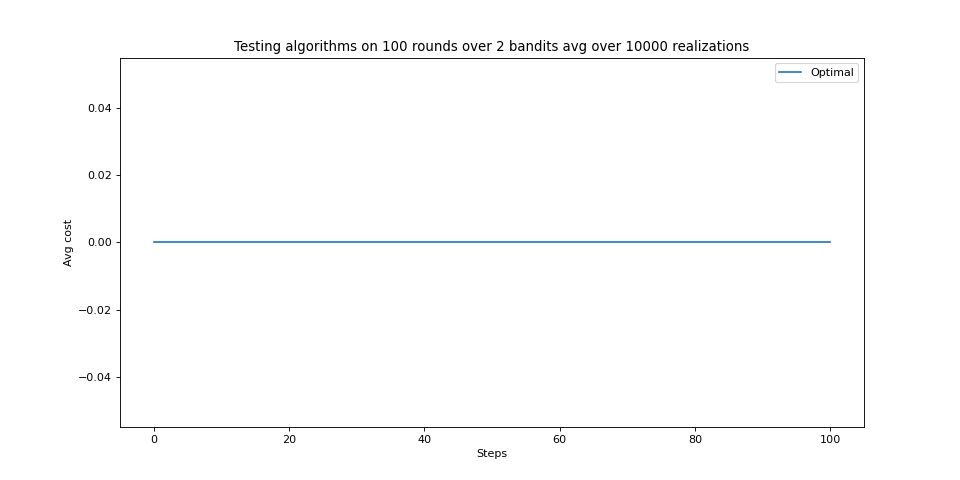

In [27]:
num_steps = 100
num_expts = 10000
num_slots = 2
epsilon = 0.1

probabilites = np.array([0.1,0.9])

p_values = np.tile(probabilites,(num_expts,1))


env = ArmedBanditsEnv(p_values)

names = ["Optimal",
         "0.1 epsilonGreedy"
    
]

agents = [
    OptimalAgent(p_values),
    EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1)


]

costs = [np.zeros((num_expts,num_steps+1))] * len(agents)

for i in tqdm(range(num_steps)):
    costs,agents = test_cost(costs,i,agents,env)
    

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')

estimates=[]
estimates.append(agents[0].estimates.mean(axis=0))
costs[0] = costs[0].mean(axis=0)
regret=[]
for i in range(1,len(agents)):
    regret.append(costs[i].mean(axis=0) - costs[0])
    plt.plot(regret[i-1])
    estimates.append(agents[i].estimates.mean(axis=0))



plt.legend(names)
plt.title(f"Testing algorithms on {num_steps} rounds over {num_slots} bandits avg over {num_expts} realizations")
plt.ylabel("Avg cost")
plt.xlabel("Steps")
plt.show()


In [28]:
estimates

[array([0.1, 0.9]), array([0.65316672, 0.65797111])]